In [1]:
!pip install tensorflow-addons
!pip install -q -U keras-tuner

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import keras_tuner as kt

from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout, Embedding, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.experimental import WideDeepModel
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, Recall, MeanSquaredError, BinaryCrossentropy, Precision, TopKCategoricalAccuracy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Ftrl, Adagrad
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers
from tensorflow.keras import activations

from tensorflow_addons.losses import SigmoidFocalCrossEntropy

from keras_tuner import HyperParameters

from tensorboard.plugins.hparams import api as hp

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import datetime
from collections import Counter

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
BATCH_SIZE = 10

LOSS = SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)
METRICS = [Recall(top_k=10, name="Recall@10"), Recall(top_k=20, name="Recall@20"), Recall(top_k=50, name="Recall@50")]

AE_LOSS = SigmoidFocalCrossEntropy()
AE_METRICS = []

# Utils

## generators

In [5]:
def gen_train(batch_size, num_itemids, df):
    mlb = MultiLabelBinarizer(classes=range(1, num_itemids+1))
    mlb.fit([])
    num_batches = len(df) // batch_size
    while True:
        data = df.sample(num_batches * batch_size)
        for batch in np.array_split(data, num_batches):
            yield mlb.transform(batch['features']), mlb.transform(batch['label'])

def gen_test(batch_size, num_itemids, df):
    mlb = MultiLabelBinarizer(classes=range(1, num_itemids+1))
    mlb.fit([])
    num_batches = len(df) // batch_size
    for batch in np.array_split(df, num_batches):
        yield mlb.transform(batch['features']), mlb.transform(batch['label'])


def gen_train_ae(batch_size, num_itemids, df):
    mlb = MultiLabelBinarizer(classes=range(1, num_itemids+1))
    mlb.fit([])
    num_batches = len(df) // batch_size
    while True:
        data = df.sample(num_batches * batch_size)
        for batch in np.array_split(data, num_batches):
            features = mlb.transform(batch['features'])
            yield features, features

def gen_train_word_embed(batch_size, num_itemids, df, top_n):
    mlb = MultiLabelBinarizer(classes=range(1, num_itemids+1))
    mlb.fit([])
    num_batches = len(df) // batch_size
    while True:
        data = df.sample(num_batches * batch_size)
        for batch in np.array_split(data, num_batches):
            features = pad_sequences(batch['features'], maxlen=top_n, padding='pre', truncating='pre')
            labels = mlb.transform(batch['label'])
            yield features, labels

## paths

In [89]:
def get_path(filename):
    return f"/content/drive/My Drive/NI-MVI/{filename}"

def time_now():
    return datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def tb_dir(model_name):
    return get_path(f"models/{model_name}/tb_logs/fit/{time_now()}")

def hp_dir(model_name):
    return get_path(f"models/{model_name}/hp_tunning/{time_now()}")

def hp_tb_dir(model_name):
    return get_path(f"models/{model_name}/hp_tunning_tb/{time_now()}")

def fit_dir(model_name):
    return get_path(f"models/{model_name}/fit/{time_now()}")

def eval_dir(filename):
    return get_path(f"models/eval/{filename}")

## training and tunning

In [7]:
def get_best_hp_tunning(model_func, mf_params, model_name, num_items, train, val, gen_train, gen_val, hp_dirname=None, tb_dirname=None):
    if hp_dirname is None:
        hp_dirname = hp_dir(model_name)
    if tb_dirname is None:
        tb_dirname = hp_tb_dir(model_name)
    tuner = kt.Hyperband(model_func(*mf_params), objective='val_loss', 
                         max_epochs=10, factor=2,
                         hyperband_iterations=10,
                         directory=hp_dirname)
    
    stop_early_callback = EarlyStopping(monitor='val_loss', patience=3)
    
    tuner.search(gen_train,
                    epochs=10,
                    steps_per_epoch=len(train) // BATCH_SIZE,
                    verbose=1,
                    validation_data=gen_val,
                    validation_steps=len(val) // BATCH_SIZE,
                    callbacks=[stop_early_callback, TensorBoard(tb_dirname)])
    return tuner.get_best_hyperparameters()[0]

In [43]:
def train_model(model, model_name, num_items, train, val, gen_train, gen_val, fit_dirname=None):
    tensorboard_callback = TensorBoard(log_dir=tb_dir(model_name), histogram_freq=1)

    if fit_dirname is None:
        fit_dirname = fit_dir(model_name)
    model_checkpoint_callback = ModelCheckpoint(
            filepath=fit_dirname,
            monitor='Recall@10',
            mode='max',
            save_weights_only=True,
            save_best_only=True)
    
    stop_early_callback = EarlyStopping(monitor='Recall@10', patience=3, mode='max')

    history = model.fit(gen_train,
                epochs=10,
                steps_per_epoch=len(train) // BATCH_SIZE,
                verbose=1,
                validation_data=gen_val,
                validation_steps=len(val) // BATCH_SIZE,
                callbacks=[tensorboard_callback, model_checkpoint_callback, stop_early_callback])
    return history


def train_autoencoder(model, model_name, num_items, train, val, gen_train, gen_val, fit_dirname=None):
    tensorboard_callback = TensorBoard(log_dir=tb_dir(model_name), histogram_freq=1)

    if fit_dirname is None:
        fit_dirname = fit_dir(model_name)
    model_checkpoint_callback = ModelCheckpoint(
            filepath=fit_dirname,
            monitor='val_loss',
            mode='min',
            save_weights_only=True,
            save_best_only=True)
    
    stop_early_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

    history = model.fit(gen_train,
                epochs=10,
                steps_per_epoch=len(train) // BATCH_SIZE,
                verbose=1,
                validation_data=gen_val,
                validation_steps=len(val) // BATCH_SIZE,
                callbacks=[tensorboard_callback, model_checkpoint_callback, stop_early_callback])
    return history

In [9]:
def y_true_pred(model, num_items, data):
    y_pred = model.predict(gen_test(BATCH_SIZE, num_items, data), verbose=1)
    return data['label'], y_pred

## plotting

In [79]:
def pos_neg_histogram(y_true, y_pred, title, filename):
    positive, negative = [], []
    for idx in range(y_pred.shape[0]):
        for i, pred in enumerate(y_pred[idx]):
            if i+1 in y_true.iloc[idx]:
                positive.append(pred)
            else:
                negative.append(pred)

    fig, ax = plt.subplots()
    ax.hist([positive, negative], bins=15, density=True, label=['relevant', 'not relevant'])
    ax.legend()
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

## other for large data (not working)

In [11]:
def pos_neg_histogram_big_data(y_true, y_pred, title):
    cnt_pos = Counter()
    cnt_neg = Counter()

    pos_total = 0
    neg_total = 0

    for idx in range(y_pred.shape[0]):
        if idx % 100 == 0:
            print(f"{idx} / {y_pred.shape[0]}")
        p = [round(pred, 1) for i, pred in enumerate(y_pred[idx]) if i+1 in y_true.iloc[idx]]
        n = [round(pred, 1) for i, pred in enumerate(y_pred[idx]) if i+1 not in y_true.iloc[idx]]
        cnt_pos.update(p)
        cnt_neg.update(n)
        pos_total += len(p)
        neg_total += len(n)

    print(cnt_pos.most_common(10))
    print(cnt_neg.most_common(10))

    labels = [i / 10 for i in range(0, 10)]
    x = np.arange(len(labels))
    width = 0.35
    pos, neg = [], []
    for i in labels:
        if i in cnt_pos:
            pos.append(cnt_pos[i] / pos_total)
        else:
            pos.append(0)
        if i in cnt_neg:
            neg.append(cnt_neg[i] / neg_total)
        else:
            neg.append(0)

    print(pos)
    print(neg)

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, pos, width, label='Relevant')
    rects2 = ax.bar(x + width/2, neg, width, label='Not Relevant')
    ax.set_ylabel('Count')
    ax.set_xticks(x, labels)
    ax.legend()
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

# Evaluation

In [62]:
def evaluate(models, data, dataset_name, number_of_items):
    models_names = [model.name for model in models]
    models_results = []
    for model in models:
        r = model.evaluate(gen_test(BATCH_SIZE, number_of_items, data), return_dict=True)
        models_results.append([r['Recall@10'], r['Recall@20'], r['Recall@50']])
        print(f"{model.name}: {r}")
        y_true, y_pred = y_true_pred(model, number_of_items, data)
        pos_neg_histogram(y_true, y_pred, 
                            f"{model.name} - {dataset_name}", 
                            f"{model.name}_{dataset_name}.png")
    df = pd.DataFrame(models_results,
                        columns=['Recall@10', 'Recall@20', 'Recall@50'],
                        index=models_names)
    df.to_csv(eval_dir(f"{dataset_name}.csv"))

# TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
# %tensorboard --logdir "/content/drive/My Drive/NI-MVI/models/raw_inter/hp_tunning_tb/20211229-111238"

# Data

In [13]:
def number_of_items(filename):
    with open(filename) as f:
        df = pd.read_csv(f)
    return len(df['itemid'].unique())


def load_prepared_data(filename, num_samples=None):
    def list_converter(l):
        return [int(s_number) for s_number in l.strip('[]').split(',')]
    
    with open(filename) as f:
        df = pd.read_csv(f, index_col='userid', 
                        converters={"features": list_converter, "label": list_converter})
    
    if num_samples is not None and num_samples < len(df):
        return df.sample(num_samples)
    return df

In [14]:
def print_dataset_stats(n, df):
    print(f"Number of unique itemids: {n}")
    print(f"Length: {len(df)}")

In [66]:
num_items_pt = number_of_items(get_path("data/PT_purchases.csv"))
pt = load_prepared_data(get_path("prep_data/PT.csv"), num_samples=10000)

train_pt, test_pt = train_test_split(pt, test_size=0.2)
train_pt, val_pt = train_test_split(train_pt, test_size=0.3)

In [57]:
print_dataset_stats(num_items_pt, pt)

Number of unique itemids: 4971
Length: 310995


# Top Popular

In [34]:
class TopPopularModel(keras.Model):
    def __init__(self, top_list, num_items, top_n):
        super(TopPopularModel, self).__init__()
        self.top_list = top_list
        self.num_items = num_items
        self.top_n = top_n
    
    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        num_inputs = BATCH_SIZE
        result = np.zeros(shape=(num_inputs, self.num_items), dtype=int)
        top_values = list(range(self.top_n, 0, -1))
        top_values = [t / self.top_n for t in top_values]
        for i in range(len(inputs)):
            n = 0
            for item in self.top_list:
                if n == self.top_n:
                    break
                if tf.get_static_value(inputs[i][item]) == 0:  # user hasn't interacted with the item yet
                    result[i][item] = 1
                    n += 1
        return tf.convert_to_tensor(result, dtype=tf.float64)
    
    def train_step(self, data):
        return {}
    
    def get_config(self):
        return {"top_list": self.top_list, "num_items": self.num_items, "top_n": self.top_n}
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)


def top_items_data(filename):
    with open(filename) as f:
        df = pd.read_csv(f)
    
    # transform original itemids to continuous ids from 1 to num_itemids
    itemids = df['itemid'].unique()
    num_itemids = len(itemids)  # number of unique itemids
    itemids_sorted = np.sort(itemids)
    itemids_dict = dict(zip(itemids_sorted, range(num_itemids)))
    df['itemid'] = df['itemid'].apply(lambda x: itemids_dict[x] + 1)
    
    return df['itemid'].value_counts().index


def create_top_model(top_list, num_items, top_n):
    model = TopPopularModel(top_list, num_items, top_n)
    model.compile(loss=LOSS, metrics=METRICS)
    return model

In [33]:
pt_top_list = top_items_data("/content/drive/My Drive/NI-MVI/data/PT_purchases.csv")

In [37]:
pt_top_model = create_top_model(pt_top_list, num_items_pt, 50)

# Wide

In [67]:
def create_wide_model(input_dim):
    w_input = Input(shape=(input_dim,))
    w_output = Dense(input_dim, name="output", activation='sigmoid', kernel_regularizer='l2')(w_input)
    model = Model(inputs=w_input, outputs=w_output)
    model.compile('adam', loss=LOSS, metrics=METRICS)
    return model

In [68]:
pt_wide_model = create_wide_model(num_items_pt)
pt_wide_history = train_model(pt_wide_model, "pt_wide", num_items_pt, train_pt, val_pt,
                                gen_train(BATCH_SIZE, num_items_pt, train_pt),
                                gen_train(BATCH_SIZE, num_items_pt, val_pt))

Epoch 1/10
560/560 [==============================] - 93s 164ms/step - loss: 294.9222 - Recall@10: 0.1303 - Recall@20: 0.1572 - Recall@50: 0.1915 - val_loss: 197.0184 - val_Recall@10: 0.2531 - val_Recall@20: 0.3143 - val_Recall@50: 0.3996
Epoch 2/10
560/560 [==============================] - 112s 200ms/step - loss: 147.0003 - Recall@10: 0.2804 - Recall@20: 0.3521 - Recall@50: 0.4593 - val_loss: 113.1766 - val_Recall@10: 0.2607 - val_Recall@20: 0.3214 - val_Recall@50: 0.4041
Epoch 3/10
560/560 [==============================] - 123s 220ms/step - loss: 85.4944 - Recall@10: 0.2794 - Recall@20: 0.3471 - Recall@50: 0.4523 - val_loss: 66.6352 - val_Recall@10: 0.2503 - val_Recall@20: 0.3131 - val_Recall@50: 0.4133
Epoch 4/10
560/560 [==============================] - 112s 199ms/step - loss: 51.4181 - Recall@10: 0.2744 - Recall@20: 0.3450 - Recall@50: 0.4469 - val_loss: 40.8421 - val_Recall@10: 0.2499 - val_Recall@20: 0.3081 - val_Recall@50: 0.4051
Epoch 5/10
560/560 [=========================

# Deep

Architecture (growing, decreasing, constant, ae-like)
* deep/hp_tunning_tb/20211230-202422
* AE

AE - num layers (and neuron counts)
* deep/hp_tunning_tb/20211230-215825
* 3 layers

In [29]:
def create_deep_model(input_dim):
    units = [512, 512, 512]
    d_input = Input(shape=(input_dim,))
    deep = d_input
    for u in units:
        deep = Dense(units=u, activation='relu')(deep)
        deep = Dropout(0.5)(deep)
    d_output = Dense(input_dim, activation='sigmoid')(deep)
    model = Model(inputs=d_input, outputs=d_output)
    model.compile('adam', loss=LOSS, metrics=METRICS)
    return model

In [30]:
pt_deep_model = create_deep_model(num_items_pt)
pt_deep_history = train_model(pt_deep_model, "pt_deep", num_items_pt, train_pt, val_pt, 
                            gen_train(BATCH_SIZE, num_items_pt, train_pt), 
                            gen_train(BATCH_SIZE, num_items_pt, val_pt))

Epoch 1/10
560/560 [==============================] - 21s 36ms/step - loss: 11.7005 - Recall@10: 0.1611 - Recall@20: 0.2206 - Recall@50: 0.3242 - val_loss: 1.5595 - val_Recall@10: 0.1424 - val_Recall@20: 0.2085 - val_Recall@50: 0.3093
Epoch 2/10
560/560 [==============================] - 24s 42ms/step - loss: 1.7793 - Recall@10: 0.1365 - Recall@20: 0.2049 - Recall@50: 0.3030 - val_loss: 1.4591 - val_Recall@10: 0.1996 - val_Recall@20: 0.2690 - val_Recall@50: 0.3560
Epoch 3/10
560/560 [==============================] - 22s 39ms/step - loss: 1.6504 - Recall@10: 0.1788 - Recall@20: 0.2439 - Recall@50: 0.3328 - val_loss: 1.4198 - val_Recall@10: 0.2243 - val_Recall@20: 0.2870 - val_Recall@50: 0.3732
Epoch 4/10
560/560 [==============================] - 19s 35ms/step - loss: 1.5612 - Recall@10: 0.2100 - Recall@20: 0.2685 - Recall@50: 0.3564 - val_loss: 1.4091 - val_Recall@10: 0.2479 - val_Recall@20: 0.3046 - val_Recall@50: 0.3874
Epoch 5/10
560/560 [==============================] - 20s 35ms/

# Raw interactions WD

In [38]:
def create_raw_wd_model(input_dim, wide_func, deep_func):
    wide_model = wide_func(input_dim)
    deep_model = deep_func(input_dim)

    model = WideDeepModel(wide_model, deep_model, activation='sigmoid')
    model.compile(optimizer='adam', loss=LOSS, metrics=METRICS)
    return model

In [40]:
pt_raw_wd_model = create_raw_wd_model(num_items_pt, create_wide_model, create_deep_model)
pt_raw_wd_history = train_model(pt_raw_wd_model, "pt_raw_wd", num_items_pt, train_pt, val_pt, 
                            gen_train(BATCH_SIZE, num_items_pt, train_pt), 
                            gen_train(BATCH_SIZE, num_items_pt, val_pt))

Epoch 1/10
560/560 [==============================] - 120s 211ms/step - loss: 1199.8083 - Recall@10: 0.1485 - Recall@20: 0.1739 - Recall@50: 0.1986 - val_loss: 1078.0603 - val_Recall@10: 0.2549 - val_Recall@20: 0.3122 - val_Recall@50: 0.3584
Epoch 2/10
560/560 [==============================] - 177s 317ms/step - loss: 1010.9140 - Recall@10: 0.2783 - Recall@20: 0.3558 - Recall@50: 0.4420 - val_loss: 958.3486 - val_Recall@10: 0.2744 - val_Recall@20: 0.3459 - val_Recall@50: 0.4348
Epoch 3/10
560/560 [==============================] - 181s 324ms/step - loss: 910.0687 - Recall@10: 0.2734 - Recall@20: 0.3527 - Recall@50: 0.4485 - val_loss: 872.1220 - val_Recall@10: 0.2637 - val_Recall@20: 0.3368 - val_Recall@50: 0.4226
Epoch 4/10
560/560 [==============================] - 143s 256ms/step - loss: 838.3463 - Recall@10: 0.2668 - Recall@20: 0.3368 - Recall@50: 0.4272 - val_loss: 811.1930 - val_Recall@10: 0.2557 - val_Recall@20: 0.3339 - val_Recall@50: 0.4186
Epoch 5/10
560/560 [=================

In [91]:
def create_raw_wd_model2(input_dim, wide_model, deep_model):
    model = WideDeepModel(wide_model, deep_model, activation='sigmoid')
    model.compile(optimizer='adam', loss=LOSS, metrics=METRICS)
    return model

In [92]:
pt_raw_wd_model2 = create_raw_wd_model2(num_items_pt, pt_wide_model, pt_deep_model)
pt_raw_wd_history2 = train_model(pt_raw_wd_model2, "pt_raw_wd2", num_items_pt, train_pt, val_pt, 
                            gen_train(BATCH_SIZE, num_items_pt, train_pt), 
                            gen_train(BATCH_SIZE, num_items_pt, val_pt))

Epoch 1/10
560/560 [==============================] - 122s 216ms/step - loss: 813.4577 - Recall@10: 0.2340 - Recall@20: 0.2997 - Recall@50: 0.4134 - val_loss: 782.5731 - val_Recall@10: 0.2029 - val_Recall@20: 0.2663 - val_Recall@50: 0.3624
Epoch 2/10
560/560 [==============================] - 111s 199ms/step - loss: 757.6670 - Recall@10: 0.2103 - Recall@20: 0.2755 - Recall@50: 0.3819 - val_loss: 739.1492 - val_Recall@10: 0.1944 - val_Recall@20: 0.2518 - val_Recall@50: 0.3523
Epoch 3/10
560/560 [==============================] - 114s 203ms/step - loss: 723.6901 - Recall@10: 0.2052 - Recall@20: 0.2628 - Recall@50: 0.3758 - val_loss: 711.7275 - val_Recall@10: 0.1807 - val_Recall@20: 0.2479 - val_Recall@50: 0.3481
Epoch 4/10
560/560 [==============================] - 113s 201ms/step - loss: 701.7346 - Recall@10: 0.1947 - Recall@20: 0.2567 - Recall@50: 0.3655 - val_loss: 693.7385 - val_Recall@10: 0.1863 - val_Recall@20: 0.2364 - val_Recall@50: 0.3449


# Word embedding

In [41]:
def create_word_wd_model(input_dim, embed_dim, top_n):
    w_input = Input(shape=(top_n,))
    w_embedding = Embedding(input_dim=input_dim, output_dim=embed_dim, input_length=top_n, mask_zero=True)(w_input)
    w_flat_embed = Flatten()(w_embedding)
    w_output = Dense(input_dim, name="output", activation='sigmoid', kernel_regularizer='l2')(w_input)
    wide_model = Model(inputs=w_input, outputs=w_output)

    d_input = Input(shape=(top_n,))
    d_embedding = Embedding(input_dim=input_dim, output_dim=embed_dim, input_length=top_n, mask_zero=True)(d_input)
    d_flat_embed = Flatten()(d_embedding)
    deep = d_flat_embed
    for u in [512, 512, 512]:
        deep = Dense(units=u, activation='relu')(deep)
        deep = Dropout(0.5)(deep)
    d_output = Dense(input_dim, activation='sigmoid')(deep)
    deep_model = Model(inputs=d_input, outputs=d_output)

    model = WideDeepModel(wide_model, deep_model, activation='sigmoid')
    model.compile(optimizer='adam', loss=LOSS, metrics=METRICS)
    return model

In [42]:
top_n = 10  # according how many last items are the predictions for the given user made
pt_word_wd_model = create_word_wd_model(num_items_pt, 64, top_n)
pt_word_wd_history = train_model(pt_word_wd_model, "pt_word_wd", num_items_pt, train_pt, val_pt, 
                            gen_train_word_embed(BATCH_SIZE, num_items_pt, train_pt, top_n), 
                            gen_train_word_embed(BATCH_SIZE, num_items_pt, val_pt, top_n))

Epoch 1/10
560/560 [==============================] - 20s 33ms/step - loss: 694.5772 - Recall@10: 0.0745 - Recall@20: 0.0961 - Recall@50: 0.1242 - val_loss: 646.2699 - val_Recall@10: 7.6380e-04 - val_Recall@20: 0.0017 - val_Recall@50: 0.0063
Epoch 2/10
560/560 [==============================] - 18s 32ms/step - loss: 646.1737 - Recall@10: 5.5764e-04 - Recall@20: 0.0018 - Recall@50: 0.0063 - val_loss: 646.1430 - val_Recall@10: 7.6321e-04 - val_Recall@20: 0.0017 - val_Recall@50: 0.0063
Epoch 3/10
560/560 [==============================] - 17s 31ms/step - loss: 646.0970 - Recall@10: 5.5764e-04 - Recall@20: 0.0018 - Recall@50: 0.0065 - val_loss: 646.1034 - val_Recall@10: 7.6453e-04 - val_Recall@20: 0.0017 - val_Recall@50: 0.0063
Epoch 4/10
560/560 [==============================] - 17s 30ms/step - loss: 646.0699 - Recall@10: 5.5764e-04 - Recall@20: 0.0018 - Recall@50: 0.0066 - val_loss: 646.0845 - val_Recall@10: 7.6278e-04 - val_Recall@20: 0.0017 - val_Recall@50: 0.0061


# Autoencoder embedding

In [46]:
def create_autoencoder(input_dim, encoding_dim):
    num_layers = 2
    units = [768, 512]

    input_ = Input(shape=(input_dim, ), name="input")
    encoded = input_
    for i in range(num_layers):
        encoded = Dense(units=units[i], activation='relu', name=f"encoding_{i}")(encoded)
    encoded = Dense(encoding_dim, name="encoded_output")(encoded)

    decoded = encoded
    for i in range(num_layers - 1, -1, -1):
        decoded = Dense(units=units[i], activation='relu', name=f"decoding_{i}")(decoded)
    decoded = Dense(input_dim, activation='sigmoid', name="decoded_output")(decoded)

    autoencoder = Model(input_, decoded)

    autoencoder.compile(optimizer='adam', loss=AE_LOSS, metrics=AE_METRICS)
    return autoencoder

In [50]:
encoding_dim = 128

In [45]:
pt_autoencoder_model = create_autoencoder(num_items_pt, encoding_dim)
pt_autoencoder_history = train_autoencoder(pt_autoencoder_model, "pt_autoencoder", num_items_pt, train_pt, val_pt, 
                            gen_train(BATCH_SIZE, num_items_pt, train_pt),
                            gen_train(BATCH_SIZE, num_items_pt, val_pt))

Epoch 1/10
560/560 [==============================] - 27s 46ms/step - loss: 13.7061 - val_loss: 4.1389
Epoch 2/10
560/560 [==============================] - 27s 49ms/step - loss: 1.8106 - val_loss: 1.4513
Epoch 3/10
560/560 [==============================] - 27s 48ms/step - loss: 1.5746 - val_loss: 1.5013
Epoch 4/10
560/560 [==============================] - 33s 59ms/step - loss: 1.6906 - val_loss: 1.4720
Epoch 5/10
560/560 [==============================] - 27s 48ms/step - loss: 1.5088 - val_loss: 1.4508
Epoch 6/10
560/560 [==============================] - 31s 55ms/step - loss: 1.4201 - val_loss: 1.5335
Epoch 7/10
560/560 [==============================] - 35s 63ms/step - loss: 1.4367 - val_loss: 1.4626
Epoch 8/10
560/560 [==============================] - 34s 61ms/step - loss: 1.3383 - val_loss: 1.4681


In [47]:
encoder = Model(pt_autoencoder_model.get_layer(name="input").output, pt_autoencoder_model.get_layer(name="encoded_output").output)
decoder = Model(pt_autoencoder_model.get_layer(name="encoded_output").output, pt_autoencoder_model.get_layer(name="decoded_output").output)

In [54]:
def create_ae_wd_model(input_dim, encoding_dim, encoder, decoder):
    input_ = Input(shape=(input_dim,), name="input")
    encoded_input = encoder(input_)
    
    w_output = Dense(encoding_dim, name="output", activation='sigmoid', kernel_regularizer='l2')(encoded_input)
    w_decoded = decoder(w_output)
    wide_model = Model(inputs=input_, outputs=w_decoded)

    deep = encoded_input
    for u in [64, 64]:
        deep = Dense(units=u, activation='relu')(deep)
        deep = Dropout(0.5)(deep)
    d_output = Dense(encoding_dim, activation='sigmoid')(deep)
    d_decoded = decoder(d_output)
    deep_model = Model(inputs=input_, outputs=d_decoded)

    model = WideDeepModel(wide_model, deep_model, activation='sigmoid')

    model.compile('adam', loss=LOSS, metrics=METRICS)
    return model

In [55]:
pt_ae_wd_model = create_ae_wd_model(num_items_pt, encoding_dim, encoder, decoder)
pt_ae_wd_history = train_model(pt_ae_wd_model, "pt_ae_wd", num_items_pt, train_pt, val_pt, 
                            gen_train(BATCH_SIZE, num_items_pt, train_pt), 
                            gen_train(BATCH_SIZE, num_items_pt, val_pt))

Epoch 1/10
560/560 [==============================] - 75s 128ms/step - loss: 647.3889 - Recall@10: 0.0020 - Recall@20: 0.0038 - Recall@50: 0.0092 - val_loss: 646.6722 - val_Recall@10: 7.6380e-04 - val_Recall@20: 0.0019 - val_Recall@50: 0.0069
Epoch 2/10
560/560 [==============================] - 80s 144ms/step - loss: 646.5048 - Recall@10: 4.7797e-04 - Recall@20: 0.0018 - Recall@50: 0.0064 - val_loss: 646.3712 - val_Recall@10: 7.6409e-04 - val_Recall@20: 0.0019 - val_Recall@50: 0.0069
Epoch 3/10
560/560 [==============================] - 71s 127ms/step - loss: 646.2635 - Recall@10: 4.7797e-04 - Recall@20: 0.0018 - Recall@50: 0.0064 - val_loss: 646.1806 - val_Recall@10: 7.6482e-04 - val_Recall@20: 0.0019 - val_Recall@50: 0.0069
Epoch 4/10
560/560 [==============================] - 65s 116ms/step - loss: 646.1091 - Recall@10: 4.7797e-04 - Recall@20: 0.0018 - Recall@50: 0.0064 - val_loss: 646.0566 - val_Recall@10: 7.6104e-04 - val_Recall@20: 0.0019 - val_Recall@50: 0.0068


# Evaluation

In [101]:
models = [pt_top_model, pt_wide_model, pt_deep_model, pt_raw_wd_model, pt_raw_wd_model2, pt_ae_wd_model]#, pt_word_wd_model]

1/1 [==============================] - 0s 238ms/step - loss: 13.8825 - Recall@10: 0.0000e+00 - Recall@20: 0.0000e+00 - Recall@50: 0.0000e+00
top_popular_model: {'loss': 13.882453918457031, 'Recall@10': 0.0, 'Recall@20': 0.0, 'Recall@50': 0.0}
2/2 [==============================] - 0s 90ms/step


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


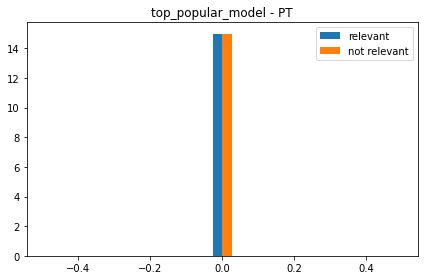

1/1 [==============================] - 0s 218ms/step - loss: 5.8866 - Recall@10: 0.3333 - Recall@20: 0.3333 - Recall@50: 0.4167
model_17: {'loss': 5.886648178100586, 'Recall@10': 0.3333333432674408, 'Recall@20': 0.3333333432674408, 'Recall@50': 0.4166666567325592}
1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 120ms/step - loss: 13.8825 - Recall@10: 0.2778 - Recall@20: 0.3333 - Recall@50: 0.3889
model_5: {'loss': 13.882453918457031, 'Recall@10': 0.2777777910232544, 'Recall@20': 0.3333333432674408, 'Recall@50': 0.3888888955116272}
1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 195ms/step - loss: 757.8332 - Recall@10: 0.2778 - Recall@20: 0.3333 - Recall@50: 0.4722
wide_deep_model: {'loss': 757.8331909179688, 'Recall@10': 0.2777777910232544, 'Recall@20': 0.3333333432674408, 'Recall@50': 0.4722222089767456}
1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 185ms/step - loss: 691.3044 - Recall@10: 0.3333 - Recall@20: 0.3333 - Recall@50: 0.4167
wide_deep_model_3: {'loss': 691.3043823242188, 'Recall@10': 0.3333333432674408, 'Recall@20': 0.3333333432674408, 'Recall@50': 0.4166666567325592}
1/1 [==============================] - 0s 148ms/step


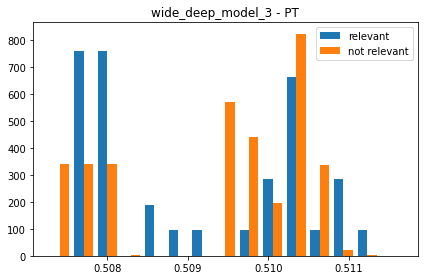

1/1 [==============================] - 0s 118ms/step - loss: 645.9346 - Recall@10: 0.0000e+00 - Recall@20: 0.0000e+00 - Recall@50: 0.0000e+00
wide_deep_model_2: {'loss': 645.9346313476562, 'Recall@10': 0.0, 'Recall@20': 0.0, 'Recall@50': 0.0}
1/1 [==============================] - 0s 116ms/step


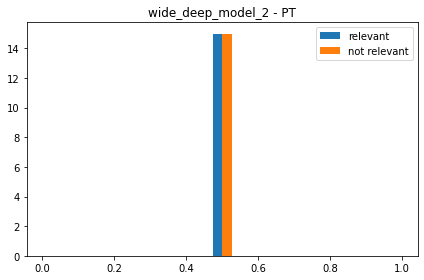

InvalidArgumentError: ignored

In [100]:
evaluate(models, test_pt[:10], "PT", num_items_pt)

In [97]:
pd.read_csv(eval_dir("PT.csv"))

Unnamed: 0  Recall@10  Recall@20  Recall@50
0  top_popular_model   0.000223   0.001116   0.004688
1           model_17   0.197991   0.253348   0.373884
2            model_5   0.161607   0.220982   0.333036
3    wide_deep_model   0.255357   0.327902   0.416295
4  wide_deep_model_3   0.197991   0.253348   0.373884
5  wide_deep_model_2   0.000223   0.001116   0.004688